In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('clean_weather.csv')

In [3]:
df

,Unnamed: 0,tmax,tmin,rain,tmax_tomorrow
0,1970-01-01,60.0,35.0,0.0,52.0
1,1970-01-02,52.0,39.0,0.0,52.0
2,1970-01-03,52.0,35.0,0.0,53.0
3,1970-01-04,53.0,36.0,0.0,52.0
4,1970-01-05,52.0,35.0,0.0,50.0
...,...,...,...,...,...
13504,2022-11-22,62.0,35.0,0.0,67.0
13505,2022-11-23,67.0,38.0,0.0,66.0
13506,2022-11-24,66.0,41.0,0.0,70.0
13507,2022-11-25,70.0,39.0,0.0,62.0


# Overall representation of RNN

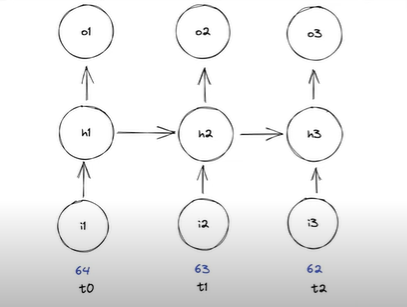

# Inside a cell of a rnn

rnn_operations.svg

Input - take in a sequence item, and multiply it by the input weight

Hidden - Take the previous hidden state, and multiply it by the hidden weight.

Output weight - Take the hidden state, and multiply by the output weight.

### Forward Pass

In [4]:
import numpy as np

# this will generate same sequence of numbers because the random number generator is initialized with the same starting state.
np.random.seed(0)

# Take the input number and turn it into 2 features
i_weight=np.random.rand(1,2)

# Hidden to hidden weight connection - 2 features to 2 features
h_weight=np.random.rand(2,2)

# Output weight connection - turn 2 features into one prediction
o_weight=np.random.rand(2,1)

i_weight, h_weight, o_weight

(array([[0.5488135 , 0.71518937]]),
 array([[0.60276338, 0.54488318],
        [0.4236548 , 0.64589411]]),
 array([[0.43758721],
        [0.891773  ]]))

In [5]:
# working with three sample temperature
temps=df['tmax'].tail(3).to_numpy()
temps

array([66., 70., 62.])

In [6]:
# xt is input for that given time step
# x0 means input at time step 0
x0=temps[0].reshape(1,1)
x1=temps[1].reshape(1,1)
x2=temps[2].reshape(1,1)

Feeding the element at the time step 0 to the network

Xi: It is the input state at t time step

Xh: It is the hidden state at t time step

Xo: it is output state at t time step

In [7]:
# @ is the matrix multiplication and it is the xi at timestep 0
xi_0=x0 @ i_weight
xi_0

array([[36.22169126, 47.20249818]])

In [8]:
# this is the relu activation function which will set the numbers less than zero to zero
# # There is no previous time step, so there is no hidden state so applying relu at time step 0
xh_0=np.maximum(0,xi_0)
xh_0

array([[36.22169126, 47.20249818]])

In [9]:
# Get the output at time step 0 xo_0
xo_0 = xh_0 @ o_weight
xo_0

array([[57.94406231]])

We can then move the network forward to time step 1:

In [10]:
# xo_0 is our prediction for the next step in the sequence.
xi_1=x1 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_0 by the hidden weights
xh=xh_0 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 1
xh_1 = np.maximum(0, xh + xi_1)


# We again find the output by multiplying xh_1 by the output weight
xo_1 = xh_1 @ o_weight

xi_1, xh_1, xo_1

(array([[38.41694527, 50.06325565]]),
 array([[ 80.24761908, 100.28766177]]),
 array([[124.54916092]]))

Doing the same for the time step 2

In [11]:
# We feed the input in the same way as the previous time step
xi_2 = x2 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_1 by the hidden weights
xh = xh_1 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 2
xh_2 = np.maximum(0, xh + xi_2)

# We again find the output by multiplying xh_1 by the output weight
xo_2 = xh_2 @ o_weight

xo_2

array([[190.94853131]])

As it can be seen that the ouput in each state gets bigger and bigger, this is because the hidden state kept getting larger and larger. Unlike the sigmoid or softmax activation functions, relu doesn't change the scale of the inputs at all (it just sets some to 0). This means that some values get repeatedly multiplied and grow larger and larger.

To avoid this we use a tanh activation function;
The tanh activation function is defined as:

$$\tanh = \dfrac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

As x gets large, $e^{x}$ gets very big, and $e^{-x}$ gets very small.  This pushes the output of $\tanh$ towards `1`.  When x gets very small (negative), $e^{-x}$ gets very large, and $e^{x}$ gets very small.  This results in `-1`.


tanh  outputs values between -1 and 1. It also has a very steep slope before and after 0 on the x-axis. The tanh activation function is better for our purposes than sigmoid because it enables us to have negative values. This enables the gradient to be steeper, which aids in gradient descent.

## Full Forward Pass

We now know enough to put together a complete RNN forward pass.  We'll first initialize our weights and biases.  We'll add in bias terms in the hidden and output steps.

We'll also scale the weights and biases to work properly with the $\tanh$ nonlinearity.  We'll make our input and hidden weights small, so $\tanh$ doesn't squash all the values to `1` or `-1`.  We'll make the output weight large, since the output of the hidden step will be small (between `1` and `-1`).  Of course, in a full RNN, the network would eventually learn the correct parameters.  But initializing weights and biases to the correct ranges helps with gradient descent.

In [12]:
import numpy as np
np.random.seed(0)

# Scale them down so values get through the tanh nonlinearity
i_weight = np.random.rand(1,5) / 5 - .1
h_weight = np.random.rand(5,5) / 5 - .1
h_bias = np.random.rand(1,5) / 5 - .1

# Tanh pushes values to between -1 and 1, so scale up the output weights
o_weight = np.random.rand(5,1) * 50
o_bias = np.random.rand(1,1)

In [13]:
output=np.zeros(3)
hidden=np.zeros((3,5))

prev_hidden=None
seq=df["tmax"].tail(3).to_numpy()

In [14]:
for i in range(3):
  x=seq[i].reshape(1,1)

  xi= x @ i_weight

  if prev_hidden is not None:
    xh = xi + prev_hidden @ h_weight + h_bias
  else:
    xh=xi

  # activation function
  xh=np.tanh(xh)
  prev_hidden=xh

  # for the back propogation
  hidden[i,]=xh

  xo=xh @ o_weight + o_bias

  output[i]=xo

  prev_hidden=xh

<ipython-input-14-9ed0aee157fd>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i]=xo


In [15]:
output

array([74.31470595, 80.66149404, 77.67852446])

In [16]:
hidden

array([[ 0.56784618,  0.99320288,  0.87557333,  0.53166114, -0.76483255],
       [ 0.58366756,  0.99568651,  0.90034879,  0.69338529, -0.84149203],
       [ 0.5383306 ,  0.99164251,  0.86287584,  0.66091071, -0.80543591]])

# Calculating Loss

In [17]:
def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

def mse_grad(actual, predicted):
    return (predicted - actual)

In [18]:
# Actual next day temperatures
actuals = np.array([70, 62, 65])

loss_grad = mse_grad(actuals, output)
loss_grad

array([ 4.31470595, 18.66149404, 12.67852446])

# Back propogation

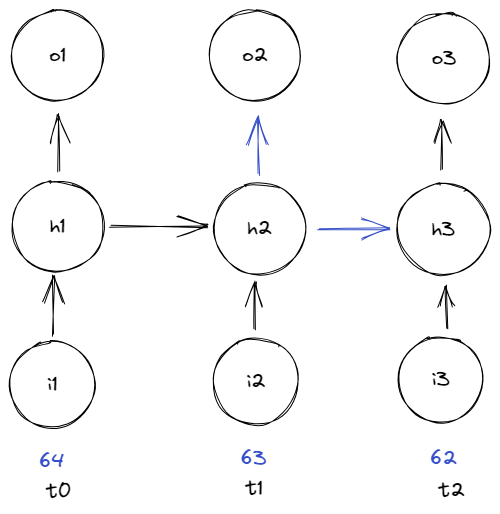

The hidden step at time step 2 is connected to both the output and the next hidden state. So it affects not just the current output, but all subsequent outputs, too.

We have to consider this fact when we do backpropagation - some parameters will impact multiple outputs. This means that they need to get gradients from multiple outputs to be properly adjusted.

We'll have to send the gradient with respect to each hidden step backwards to the previous sequence position. This is called backpropagation through time, and it's how we train the parameters of an RNN.

Here are the operations we will follow to do a backward pass. They're essentially a reverse of the forward pass:

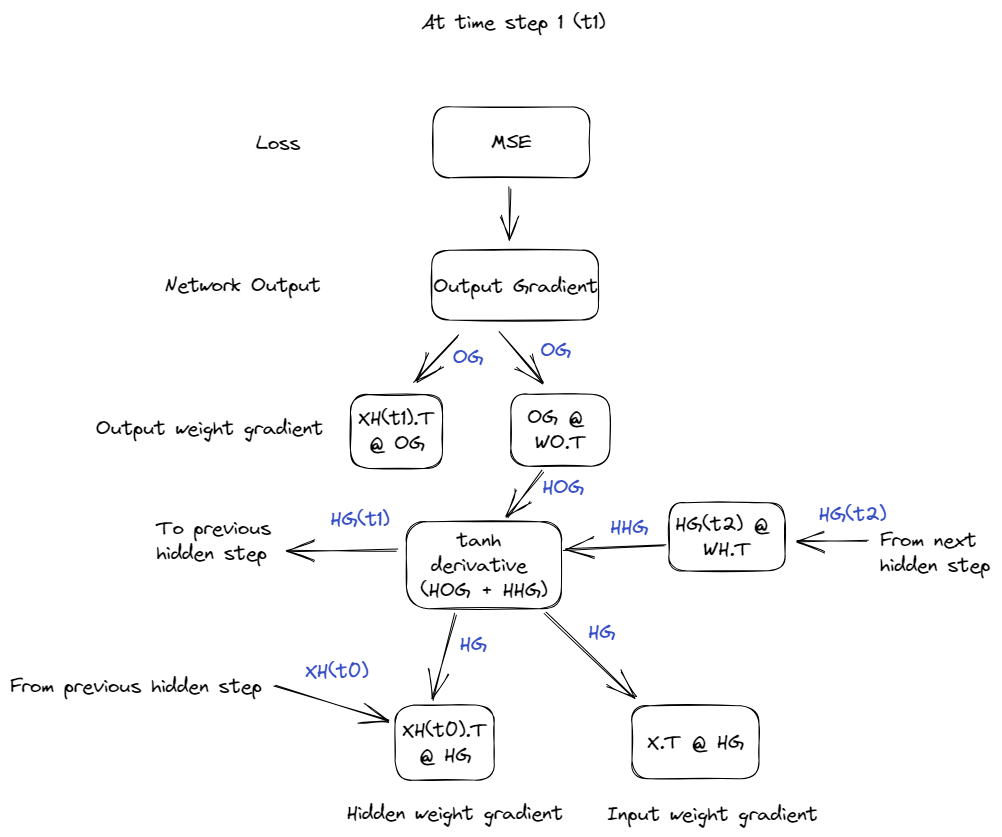

In [19]:
# instead of tracking the prev state, now we will take care of next state
next_hidden=None

o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5
o_weight_grad

0

Then, we can run backpropagation for the last sequence element (we start at the end). In this case, there is no next hidden state, so we only need to worry about the gradient wrt the output at this position:

In [21]:
# the loss at position 2
l2_grad=loss_grad[2].reshape(1,1)

# Add to the output weight gradient
# Multiply the output of the hidden step (hiddens[2]) transposed by the l2 grad
# np.newaxis creates a new size 1 axis, effectively transposing the hiddens

# This means that the output weigh is dependent on hidden state at that time step and the gradeient loss at that time step
# based on the gradient how much we need to change the weights
o_weight_grad +=hidden[i][:, np.newaxis] @ l2_grad

# Add to the bias gradient.  Similar to a dense neural network, this is just the mean of the l2_grad.
o_bias_grad += np.mean(l2_grad)

# Find the gradient wrt the hidden step output , .T mean transpose
h2_grad = l2_grad @ o_weight.T

# Derivative of the tanh function
tanh_deriv = 1 - hidden[2,:][np.newaxis,:] ** 2
# Multiply each position in the h_grad by the tanh derivative - this "undoes" the tanh in the forward pass
h2_grad = np.multiply(h2_grad, tanh_deriv)

# Now, find how much we need to update the hidden weights.
# We take the input to the hidden step (the output of the previous hidden step in the forward pass) @ h2_grad
h_weight_grad += hidden[1,:][:,np.newaxis] @ h2_grad
h_bias_grad += np.mean(h2_grad)

# This multiples the sequence value at time step 2 by the gradient
# We don't need the .T here, but I left it here in case you have a larger input size
i_weight_grad += seq[2].reshape(1,1).T @ h2_grad

l2_grad

array([[12.67852446]])

In [ ]:
l1_grad=loss_grad[1].reshape(1,1)

o_weight_grad +=hidden[1][:, np.newaxis] @ l1_grad
o_bias_grad += np.mean(l1_grad)

h1_grad=l1_grad @ o_weight.T

# We do have a next sequence position (2), so we need to include that gradient
# We multiply the h2 gradient by the weight to pull it back to the current sequence position
h1_grad += h2_grad @ h_weight.T

# The rest of the operation is the same
tanh_deriv = 1 - himdden[1,:][np.newaxis,:] ** 2
h1_grad = np.multiply(h1_grad, tanh_deriv)

h_weight_grad += hidden[1,:][:,np.newaxis] @ h1_grad
h_bias_grad += np.mean(h1_grad)

i_weight_grad += seq[1].reshape(1,1).T @ h1_grad


# Full backward Pass

In [ ]:
next_hidden = None

o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5

In [ ]:
for i in range(2,-1,-1):
  l_grad = loss_grad[i].reshape(1,1)

  o_weight_grad += hiddens[i][:,np.newaxis] @ l_grad
  o_bias_grad +=np.mean(l_grad)

  o_grad = l_grad @ o_weight.T

  if next_hidden is not None:
    h_grad= o_grad + next_hidden @ h_weight.T
  else:
    h_grad = o_grad

  tanh_deriv = 1 - hiddens[i,:][np.newaxis,:] ** 2
  h_grad = np.multiply(h_grad, tanh_deriv)

  next_hidden = h_grad

  # Don't update the hidden weights for the first sequence position
  if i > 0:
    h_weight_grad += hiddens[i-1,:][:,np.newaxis] @ h_grad
    h_bias_grad += np.mean(h_grad)

  i_weight_grad += sequence[i].reshape(1,1).T @ h_grad





